In [1]:
!pip install eli5==0.13.0

# 한글 폰트 사용을 위한 라이브러리입니다.
!apt-get install -y fonts-nanum

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [3]:
train_path = "../data/train.csv"
test_path = "../data/test.csv"
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [5]:
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [23]:
dt.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000,0


In [24]:
dt_test.head(1)

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,1


In [8]:
dt['target']

0          124000
1          123500
2           91500
3          130000
4          117000
            ...  
1118817     20000
1118818     20000
1118819     28000
1118820     29000
1118821     13250
Name: target, Length: 1118822, dtype: int64

In [9]:
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])

In [13]:
concat['is_test'].value_counts()

is_test
0    1118822
1       9272
Name: count, dtype: int64

In [14]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

In [20]:
display(concat['등기신청일자'].value_counts())

등기신청일자
            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: count, Length: 182, dtype: int64

In [21]:
display(concat['거래유형'].value_counts())

거래유형
-       1086451
중개거래      38123
직거래        3520
Name: count, dtype: int64

In [18]:
display(concat['중개사소재지'].value_counts())

중개사소재지
-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: count, Length: 739, dtype: int64

In [25]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [29]:
concat.count()

시군구                       1128094
번지                        1127867
본번                        1128019
부번                        1128019
아파트명                      1125958
전용면적                      1128094
계약년월                      1128094
계약일                       1128094
층                         1128094
건축년도                      1128094
도로명                       1128094
해제사유발생일                      6195
등기신청일자                      16823
거래유형                        41643
중개사소재지                      38081
k-단지분류(아파트,주상복합등등)         250821
k-전화번호                     251244
k-팩스번호                     248746
단지소개기존clob                  69136
k-세대타입(분양형태)               251969
k-관리방식                     251969
k-복도유형                     251640
k-난방방식                     251969
k-전체동수                     250887
k-전체세대수                    251969
k-건설사(시공사)                 250457
k-시행사                      250260
k-사용검사일-사용승인일              251835
k-연면적                      251969
k-주거전용면적      

In [30]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

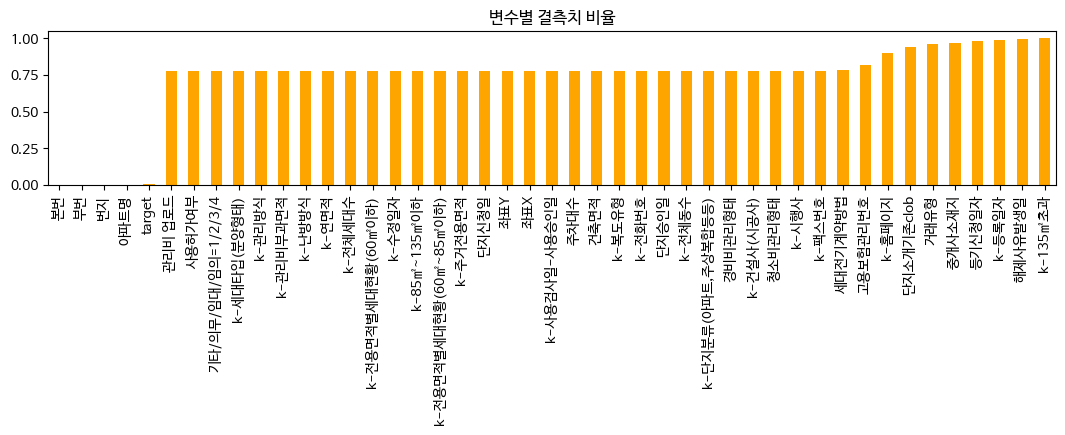

In [37]:
fig = plt.figure(figsize=(13,2))
missing = concat.isnull().sum() / concat.shape[0] #전체 데이터 개수 대비 null 
missing = missing[missing > 0]
missing.sort_values(inplace = True)
missing.plot.bar(color = 'orange')
plt.title('변수별 결측치 비율')
plt.show()

In [45]:
selected = list(concat.columns[concat.isnull().sum() <= 1000000])
print(len(selected))
concat_select = concat[selected]

45


In [50]:
unselected = list(concat.columns[concat.isnull().sum() > 1000000])
print(unselected) #결측치에서 제거된 항목

['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [51]:
concat_select.isnull().sum()

시군구                            0
번지                           227
본번                            75
부번                            75
아파트명                        2136
전용면적                           0
계약년월                           0
계약일                            0
층                              0
건축년도                           0
도로명                            0
k-단지분류(아파트,주상복합등등)        877273
k-전화번호                    876850
k-팩스번호                    879348
k-세대타입(분양형태)              876125
k-관리방식                    876125
k-복도유형                    876454
k-난방방식                    876125
k-전체동수                    877207
k-전체세대수                   876125
k-건설사(시공사)                877637
k-시행사                     877834
k-사용검사일-사용승인일             876259
k-연면적                     876125
k-주거전용면적                  876170
k-관리비부과면적                 876125
k-전용면적별세대현황(60㎡이하)        876170
k-전용면적별세대현황(60㎡~85㎡이하)    876170
k-85㎡~135㎡이하              876170
k-수정일자                    876170
고용보험관리번호  

In [52]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1128094 entries, 0 to 9271
Data columns (total 45 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1128094 non-null  object 
 1   번지                      1127867 non-null  object 
 2   본번                      1128019 non-null  float64
 3   부번                      1128019 non-null  float64
 4   아파트명                    1125958 non-null  object 
 5   전용면적                    1128094 non-null  float64
 6   계약년월                    1128094 non-null  int64  
 7   계약일                     1128094 non-null  int64  
 8   층                       1128094 non-null  int64  
 9   건축년도                    1128094 non-null  int64  
 10  도로명                     1128094 non-null  object 
 11  k-단지분류(아파트,주상복합등등)      250821 non-null   object 
 12  k-전화번호                  251244 non-null   object 
 13  k-팩스번호                  248746 non-null   object 
 14  k-세대타입(분양형

In [53]:
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [54]:
continuous_columns = [] #연속형 변수
categorical_columns = [] #범주형 변수

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else :
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일']


In [75]:
# concat_select.index[concat_select['아파트명'] == '개포주공7단지']
concat_select.iloc[1003]

시군구                       서울특별시 강남구 개포동
번지                                  185
본번                                185.0
부번                                  0.0
아파트명                            개포주공7단지
전용면적                              73.26
계약년월                             201712
계약일                                   8
층                                     3
건축년도                               1983
도로명                             개포로 516
k-단지분류(아파트,주상복합등등)                  NaN
k-전화번호                              NaN
k-팩스번호                              NaN
k-세대타입(분양형태)                        NaN
k-관리방식                              NaN
k-복도유형                              NaN
k-난방방식                              NaN
k-전체동수                              NaN
k-전체세대수                             NaN
k-건설사(시공사)                          NaN
k-시행사                               NaN
k-사용검사일-사용승인일                       NaN
k-연면적                               NaN
k-주거전용면적                            NaN


In [76]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [99]:
concat_select.iloc[1003]

시군구                       서울특별시 강남구 개포동
번지                                  185
본번                                185.0
부번                                  0.0
아파트명                            개포주공7단지
전용면적                              73.26
계약년월                             201712
계약일                                   8
층                                     3
건축년도                               1983
도로명                             개포로 516
k-단지분류(아파트,주상복합등등)                 NULL
k-전화번호                             NULL
k-팩스번호                             NULL
k-세대타입(분양형태)                       NULL
k-관리방식                             NULL
k-복도유형                             NULL
k-난방방식                             NULL
k-전체동수                         27.27095
k-전체세대수                     4308.108007
k-건설사(시공사)                         NULL
k-시행사                              NULL
k-사용검사일-사용승인일                      NULL
k-연면적                      491473.70298
k-주거전용면적                  343812.078212


In [100]:
concat_select.isnull().sum()  

시군구                       0
번지                        0
본번                        0
부번                        0
아파트명                      0
전용면적                      0
계약년월                      0
계약일                       0
층                         0
건축년도                      0
도로명                       0
k-단지분류(아파트,주상복합등등)        0
k-전화번호                    0
k-팩스번호                    0
k-세대타입(분양형태)              0
k-관리방식                    0
k-복도유형                    0
k-난방방식                    0
k-전체동수                    0
k-전체세대수                   0
k-건설사(시공사)                0
k-시행사                     0
k-사용검사일-사용승인일             0
k-연면적                     0
k-주거전용면적                  0
k-관리비부과면적                 0
k-전용면적별세대현황(60㎡이하)        0
k-전용면적별세대현황(60㎡~85㎡이하)    0
k-85㎡~135㎡이하              0
k-수정일자                    0
고용보험관리번호                  0
경비비관리형태                   0
세대전기계약방법                  0
청소비관리형태                   0
건축면적                      0
주차대수                

In [101]:
print(concat_select.shape)

(1128094, 45)


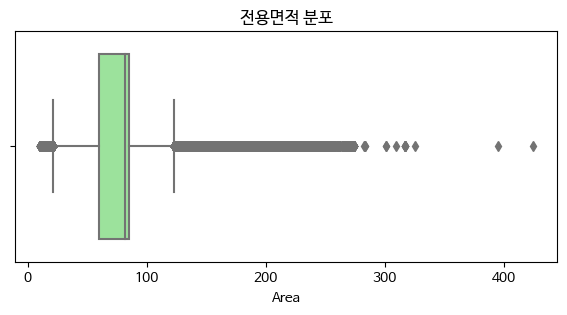

In [102]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color = 'lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [105]:
def remove_outliers_iqr(dt, column_name) :
    df = dt.query('is_test == 0')
    df_test = dt.query('is_test == 1')
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q1 + 1.5 * IQR

    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

    result = pd.concat([df, df_test])
    return result

In [106]:
concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [108]:
print(concat_select.shape)

(931793, 45)


In [109]:
concat_select['is_test'].value_counts()

is_test
0    922521
1      9272
Name: count, dtype: int64

In [ ]:
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [113]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

In [114]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12


In [117]:
all = list(concat_select['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk)


In [118]:
is_gangnam = []
for x in concat_select['구'].tolist() :
    if x in gangnam :
        is_gangnam.append(1)
    else :
        is_gangnam.append(0)

concat_select['강남여부'] = is_gangnam

In [119]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target',
       'is_test', '구', '동', '계약년', '계약월', '강남여부'],
      dtype='object')

In [120]:
concat_select['건축년도'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    931793.000000
mean       1998.496447
std           9.045054
min        1961.000000
10%        1987.000000
25%        1992.000000
50%        1999.000000
75%        2004.000000
80%        2006.000000
90%        2009.000000
max        2023.000000
Name: 건축년도, dtype: float64

In [121]:
concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [122]:
concat_select.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,계약년,계약월,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0,강남구,개포동,2017,12,1,0


In [124]:
concat_select.shape

(931793, 49)

In [125]:
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(922521, 48) (9272, 48)


In [127]:
dt_test.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동',
       '계약년', '계약월', '강남여부', '신축여부'],
      dtype='object')

In [128]:
dt_train.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식',
       'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사',
       'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)',
       'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호',
       '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4',
       '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', '구', '동',
       '계약년', '계약월', '강남여부', '신축여부'],
      dtype='object')

In [129]:
dt_test.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부
0,658-1,658.0,1.0,개포6차우성,79.97,26,5,1987,언주로 3,아파트,025776611,025776673,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,2023-09-23 17:21:41.0,NULL,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,13250.0,강남구,개포동,2023,07,1,0


In [130]:
dt_test['target'] = 0

In [131]:
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns :
    if pd.api.types.is_numeric_dtype(dt_train[column]) :
        continuous_columns_v2.append(column)
    else :
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '강남여부', '신축여부']
범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구', '동', '계약년', '계약월']


In [132]:
label_encoders = {}

for col in tqdm(categorical_columns_v2) :
    lbl = LabelEncoder()

    lbl.fit(dt_train[col].astype(str))
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl

    for label in np.unique(dt_test[col]) :
        if label not in lbl.classes_ :
            lbl.classes_ = np.append(lbl.classes_, label)
    
    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


In [133]:
dt_train.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부
0,4103,1103,1,278,79.97,8,3,1987,5253,3,436,387,2,2,1,1,8.0,270.0,231,198,24,22637.0,20204.0,22637.0,20.0,250.0,0.0,191,486,4,1,4,4858.0,262.0,4,673,1,0,127.05721,37.476763,230,124000.0,0,8,10,11,1,0


In [134]:
assert dt_train.shape[1] == dt_test.shape[1]

In [135]:
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [136]:
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [137]:
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 5122.149501490595


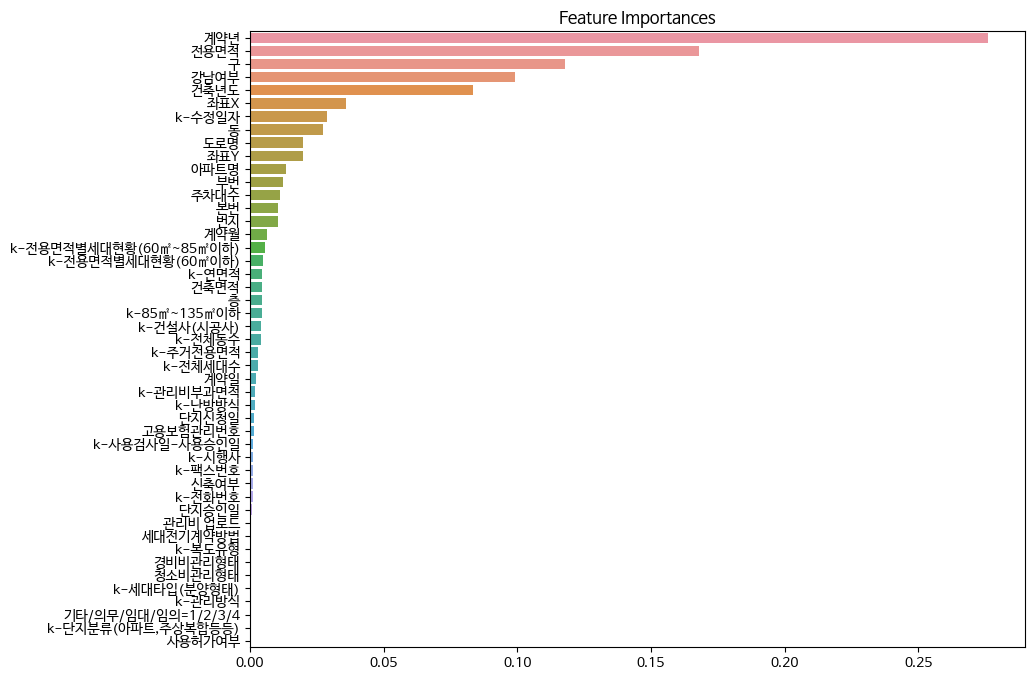

In [138]:
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [139]:
with open('saved_model.pkl', 'wb') as f :
    pickle.dump(model, f)

In [142]:
perm = PermutationImportance(model, 
                             scoring="neg_mean_squared_error", 
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())

Weight,Feature
802669063.8536 ± 5823378.9267,계약년
462985892.0758 ± 11730912.0453,강남여부
397861177.6911 ± 7233376.4825,전용면적
362473571.3737 ± 585649.6205,구
201537278.1452 ± 1562123.4709,건축년도
63654742.6685 ± 1489049.1392,좌표Y
58307434.9712 ± 354215.8684,동
56876438.8506 ± 914730.8238,좌표X
44172145.5539 ± 1733670.1816,k-수정일자
43403259.8882 ± 757432.0475,도로명


In [146]:
X_val.head(1)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부
933500,1827,618,0,4906,84.6,22,2,1997,7483,0,1011,1250,0,0,0,0,15.634052,1489.334992,71,55,625,220631.907684,124556.068546,160905.509674,580.802101,496.751797,344.784964,687,486,0,0,0,39728.065661,1761.732449,0,682,0,1,127.0513,37.661352,239,8,294,4,8,0,0


In [150]:
X_val['target'] = y_val
X_val['pred'] = pred

In [152]:
def calculate_se(target, pred) :
    squared_errors = (target - pred) ** 2
    return squared_errors

squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [153]:
X_val_sort = X_val.sort_values(by='error', ascending=False)

In [154]:
X_val_sort.head()

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
203289,3481,942,14,188,92.36,3,9,1974,4994,0,1011,1250,0,0,0,0,11.564762,626.328571,71,55,625,102413.153333,48038.730476,64827.013333,239.733333,350.075238,36.520000,687,486,0,0,0,5503.364010,826.188571,0,682,0,1,127.160600,37.550101,239,0,175,15,11,1,0,98000.0,250800.0,2.334784e+10
223619,3227,879,14,2075,86.51,14,5,2004,7433,0,1011,1250,0,0,0,0,3.838074,317.597374,71,55,625,59869.048140,32638.730853,42412.724289,57.592998,115.185996,111.509847,687,486,0,0,0,0.000000,383.544858,0,682,0,1,127.041981,37.506350,239,0,43,15,1,1,0,65000.0,188400.0,1.522756e+10
3467,3481,942,14,188,92.36,7,9,1974,4994,0,1011,1250,0,0,0,0,8.398581,713.987581,71,55,625,97118.485512,51695.516854,52835.726198,461.977528,209.873448,0.000000,687,486,0,0,0,739.432602,715.907156,0,682,0,1,127.044792,37.495711,239,0,175,11,1,1,0,55000.0,173700.0,1.408969e+10
224035,3481,942,14,188,63.31,24,4,1974,4994,0,1011,1250,0,0,0,0,4.748359,432.293217,71,55,625,73990.291028,40235.054705,52514.454413,86.115244,172.230489,166.733771,687,486,0,0,0,0.000000,573.490883,0,682,0,1,127.046122,37.497584,239,0,175,15,2,1,0,80000.0,179800.0,9.960040e+09
224523,4505,1197,0,1408,84.94,26,29,2021,5491,0,1011,1250,0,0,0,0,23.000000,2104.000000,71,55,625,272723.000000,152563.000000,202954.000000,1158.000000,828.000000,118.000000,687,486,0,0,0,11358.350000,2112.000000,0,682,0,1,126.960858,37.487309,239,0,247,15,0,1,1,208273.0,307800.0,9.905624e+09


In [155]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)

In [156]:
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [157]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
203289,510-11,510.0,11.0,강남상가,92.36,3,9,1974,압구정로2길 46,NULL,NULL,NULL,NULL,NULL,NULL,NULL,11.564762,626.328571,NULL,NULL,NULL,102413.153333,48038.730476,64827.013333,239.733333,350.075238,36.52,NULL,NULL,NULL,NULL,NULL,5503.36401,826.188571,NULL,NULL,NULL,NULL,127.1606,37.550101,NULL,강남구,신사동,2022,12,1,0,98000.0,250800.0,2.334784e+10


,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,구,동,계약년,계약월,강남여부,신축여부,target,pred,error
4889,365,365.0,0.0,강남한신휴플러스6단지,59.98,18,3,2015,밤고개로26길 50,NULL,NULL,NULL,NULL,NULL,NULL,NULL,9.715596,580.899083,NULL,NULL,NULL,77083.266055,41240.642202,41018.238532,335.119266,163.853211,81.926606,NULL,NULL,NULL,NULL,NULL,8848.944954,632.752294,NULL,NULL,NULL,NULL,127.168424,37.556713,NULL,강남구,율현동,2018,01,1,1,72000.0,72000.0,0.0


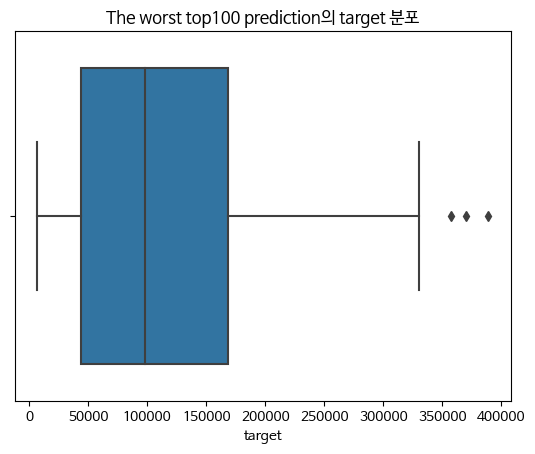

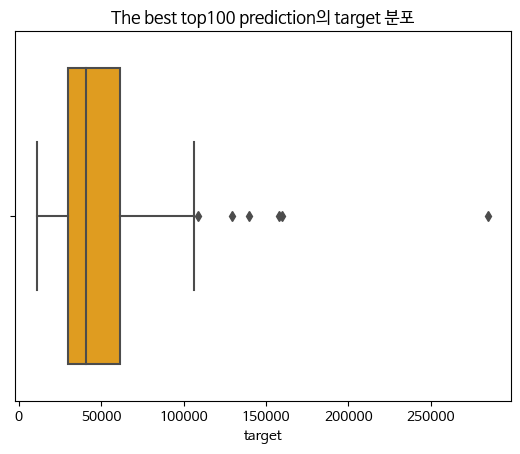

In [158]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

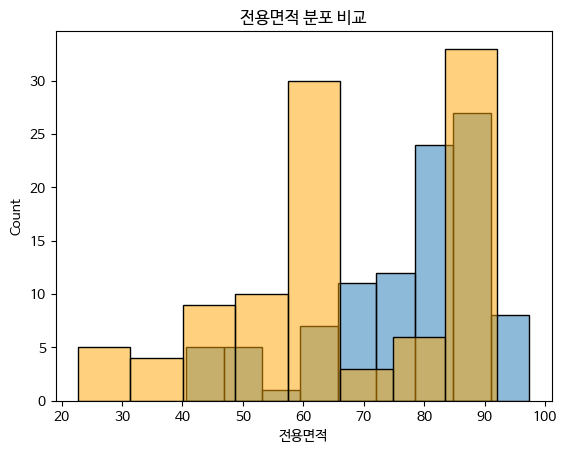

In [159]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

In [160]:
dt_test.head(2)

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,구,동,계약년,계약월,강남여부,신축여부
0,4103,1103,1,278,79.9700,26,5,1987,5253,3,436,387,2,2,1,1,8.0,270.0,231,198,24,22637.0,20204.0,22637.0,20.0,250.0,0.0,191,486,4,1,4,4858.00,262.0,4,673,1,0,127.057210,37.476763,230,0,0,8,16,6,1,0
1,4079,1096,1,5488,108.2017,15,10,2021,413,3,1033,1289,2,1,1,4,2.0,232.0,275,516,659,44951.0,24878.0,31174.0,0.0,0.0,232.0,700,486,2,2,2,2724.46,305.0,2,715,1,0,127.056394,37.484892,248,0,0,8,16,7,1,1


In [161]:
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [162]:
%%time
X_test = dt_test.drop(['target'], axis = 1)

real_test_pred = model.predict(X_test)

CPU times: user 2.56 s, sys: 4.14 ms, total: 2.57 s
Wall time: 2.54 s


In [163]:
real_test_pred

array([219400., 294400., 283000., ...,  76300.,  68540.,  71500.])

In [ ]:
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=['target'])
preds_df.to_csv('output.csv', index=False)

ValueError: Shape of passed values is (9272, 1), indices imply (9272, 2)